# Simple Autoencoder
In this notebook we will implement a simple autoencoder in Pytorch on the MNIST Dataset.

# Autoencoder

<img src="imgs/autoencoder.png">

First we important all of the packages we will use. Many of these packages are standard packages that are used when creating these networks. The exception is the MNIST package. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms
import torchvision.utils 


from torchvision.datasets import MNIST


Test if GPU is available.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if str(device) == "cuda":
    print('Using GPU')
else:
    print('Using CPU')

Using CPU


Remember that print output should be put in a log file for view in a job submission. Next we will create the folders where we will put test output and saved models.

In [3]:
# ================= Parameters ============================
num_epochs = 100
batch_size = 128
learning_rate = 1e-3

I define these parameters before I create output folders in order to name the folder of where I want the output to live. This is helpful when you are trying out different learning rates and you want to keep track of your results.

Next we will create our output folders

In [4]:
folder = 'Autoencoder_batch_size_'+str(batch_size)+'_lr='+str(learning_rate)
folder_name = '../../Documents/'+folder+'/'
if not os.path.exists(folder_name):
    os.mkdir(folder_name)
if not os.path.exists(folder_name+'/saved_models'):
    os.mkdir(folder_name+'/saved_models')
if not os.path.exists(folder_name+'/recons'):
    os.mkdir(folder_name+'/recons')

### Image Normalization
Here we pause to talk about the normalization of your inputs. We plan on using the tanh activation function at the end of this autoencoder. The tanh activation function looks like the following:

<img src="imgs/Tanh.gif">

Note that the range of the function falls within the interval -1 to 1. We therefore need to normalize our images in order for the output to match the target. There are many papers stating that normalizing the data helps reduce any skewness resulting in faster learning.

Because we are normalizing the data we need a way to undo the normalization so that we can see the images during the training process. The following helper function accomplishes this task:

In [5]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

We now will create a data loader using the trasnforms in the Pytorch API. The we compose a transform which consists of all of the actions we wish to take on the data. 

### Transform
You always want to convert the data to a tensor. This is the natural structure that pytorch deals with. 
You also always want to normalize the data as stated above. The arguments in the normalization function pertain to the mean and standard deviation. The first vector (0.5 , 0.5, 0.5) pertains to the mean of each channel the second vector pertains to the standard deviation. Normalize does the following to each channel:
image = (image - mean) / std

In [6]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader = torch.utils.data.DataLoader(MNIST('/home/odeguchy/Documents/data', train=True,download=True,
                                                transform = img_transform),batch_size=batch_size,shuffle=True)


test_loader = torch.utils.data.DataLoader(MNIST('/home/odeguchy/Documents/data',train=False,download=True,
                                               transform=img_transform),batch_size=10000,shuffle=False)


In [7]:
print('There are {} batches for training.'.format(len(train_loader)) )
print('There is {} batch for training.'.format(len(test_loader)))

There are 469 batches for training.
There is 1 batch for training.


We would like to sample one batch from the train loader. Remember this is a list structure and each item in the list is a batch. The batch is a tensor containing all of the images. 

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([3, 482, 242])
torch.Size([482, 242, 3])


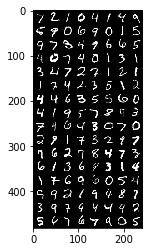

In [8]:
# Extract batch from train loader
sample_batch,_ = next(iter(test_loader))
sample_batch = sample_batch[0:128,:,:,:]
print(sample_batch.shape)

# Use the denormalization function to change the sample batch
sample_pics = to_img(sample_batch)
print(sample_pics.shape)
print(torchvision.utils.make_grid(sample_pics,nrow=8).shape)
print(torchvision.utils.make_grid(sample_pics,nrow=8).permute(1,2,0).shape)
# Use plt.imshow to display the images
plt.imshow(torchvision.utils.make_grid(sample_pics,nrow=8).permute(1, 2, 0))
plt.show()

# Save target training batch
torchvision.utils.save_image(sample_pics, '/home/odeguchy/Documents/Autoencoder_batch_size_128_lr=0.001/recons/target.png')


## Build the Network
The neural network is built in a python class structure using the nn.Module call. Here we will build the encoder and the decoder separately and then create a forward function that calls both and makes up the feed forward aspect of the network.

In [9]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), nn.Linear(64, 12), nn.ReLU(True), nn.Linear(12, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), nn.Linear(128, 28 * 28), nn.Tanh())

    def forward(self, x):
        x = x.view(-1,1*28*28)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1,1,28,28)
        return x


We now attach the model and the loss function to the hardware and define our optimization algorithm.

In [10]:
model = autoencoder().to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

## Train the Neural Network
We implement the training of the model using a couple of for loops. One for the epochs and one for the iterations across the batches.

epoch [1/100], loss:0.2030
Validation Loss: 0.1912
epoch [2/100], loss:0.1687
Validation Loss: 0.1627
epoch [3/100], loss:0.1670
Validation Loss: 0.1531
epoch [4/100], loss:0.1642
Validation Loss: 0.1475
epoch [5/100], loss:0.1491
Validation Loss: 0.1449
epoch [6/100], loss:0.1395
Validation Loss: 0.1448
epoch [7/100], loss:0.1420
Validation Loss: 0.1419
epoch [8/100], loss:0.1375
Validation Loss: 0.1422
epoch [9/100], loss:0.1333
Validation Loss: 0.1396
epoch [10/100], loss:0.1429
Validation Loss: 0.1378
epoch [11/100], loss:0.1347
Validation Loss: 0.1373
epoch [12/100], loss:0.1471
Validation Loss: 0.1354
epoch [13/100], loss:0.1323
Validation Loss: 0.1357
epoch [14/100], loss:0.1385
Validation Loss: 0.1340
epoch [15/100], loss:0.1243
Validation Loss: 0.1333
epoch [16/100], loss:0.1284
Validation Loss: 0.1320
epoch [17/100], loss:0.1382
Validation Loss: 0.1331
epoch [18/100], loss:0.1436
Validation Loss: 0.1332
epoch [19/100], loss:0.1375
Validation Loss: 0.1323
epoch [20/100], loss:

KeyboardInterrupt: 

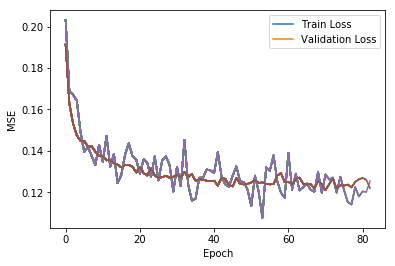

In [11]:
Train_loss = []
Validation_loss = []
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = Variable(img).to(device)
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.data.item()))
    output_val = model(Variable(sample_batch).to(device))
    loss_val = criterion(output_val, Variable(sample_batch).to(device))
    print('Validation Loss: {:.4f}'.format(loss_val.data.item()))
    # ================plotting ======================
    Train_loss.append(loss.data.item())
    Validation_loss.append(loss_val.data.item())
    x = np.arange(len(Train_loss))
    plt.plot(x,Train_loss,x,Validation_loss)
    plt.legend(('Train Loss', 'Validation Loss'))
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.savefig('/home/odeguchy/Documents/Autoencoder_batch_size_128_lr=0.001/Loss.png')
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        output_sample = model(Variable(sample_batch).to(device))
        output_sample = to_img(output_sample.cpu()).data
        torchvision.utils.save_image(output_sample, '/home/odeguchy/Documents/Autoencoder_batch_size_128_lr=0.001/recons/image_{}.png'.format(epoch+1))


## Excercises
1.) Convert the code to be useable on the cluster along with a log of the most important things. 
Note: In order to save the images and use matplotlib on the cluster you need to add

`import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt`

before adding all of the packages.

2.) Train the model for 20 epochs. Save the model and then train for another 20 epochs.
